In [ ]:
import re
from torchvision import transforms
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import BertTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from transformers import BertModel
import matplotlib.pyplot as plt
import numpy as np

## 1.数据预处理部分

In [2]:
# 文本清理函数
def clean_text(text):
    text = text.lower() # 小写
    text = re.sub(r'\s+', ' ', text)   # 去除多余空格
    text = text.strip() # 去除首尾空格
    return text

# 图像预处理
image_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 调整图像大小
    transforms.ToTensor(), # 转换为 PyTorch 张量
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # 标准化参数
        std=[0.229, 0.224, 0.225]
    )
])


In [3]:
# 数据集构建与训练
class MultimodalDataset(Dataset): # 多模态数据集类
    def __init__(self, data_list, image_dir, text_dir, tokenizer, transform=None):
        self.data_list = data_list   # [(guid, label)]
        self.image_dir = image_dir   # 图像文件夹路径
        self.text_dir = text_dir     # 文本文件夹路径
        self.tokenizer = tokenizer   # 文本分词器
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx): # 获取单个数据样本
        guid, label = self.data_list[idx]
        # 文本清洗处理
        with open(os.path.join(self.text_dir, f"{guid}.txt"), encoding="Latin-1") as f:
            text = clean_text(f.read())

        # 文本编码,转换为PyTorch张量
        text_input = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )

        # 图像处理
        img_path = os.path.join(self.image_dir, f"{guid}.jpg")
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # 文本特征、图像和标签
        return {
            "input_ids": text_input["input_ids"].squeeze(0),
            "attention_mask": text_input["attention_mask"].squeeze(0),
            "image": image,
            "label": label
        }

# 数据加载
def load_train_data(train_file):
    data = []
    label_map = {
        "negative": 0,
        "neutral": 1,
        "positive": 2
    }
    # 读取训练数据
    with open(train_file, encoding="Latin-1") as f:
        for line in f:
            if line.startswith('guid'): # 跳过表头
                continue 
            guid, label = line.strip().split(',')
            data.append((guid, label_map[label])) # 存入data列表
    return data

def load_test_data(test_file):
    data = []
    # 读取测试数据
    with open(test_file, encoding="Latin-1") as f:
        for line in f:
            if line.startswith('guid'): # 跳过表头
                continue 
            parts = line.strip().split(',')
            guid = parts[0].strip()
            data.append((guid, -1)) # 测试集标签未知，设为-1
    return data

all_data = load_train_data("project5/train.txt")
# 划分训练集、验证集、测试集
train_data, val_data = train_test_split(
    all_data,
    test_size=0.2,
    random_state=408,
    stratify=[label for _, label in all_data] # 保持标签分布一致
)
test_data=load_test_data("project5/test_without_label.txt")

In [4]:
# 加载预训练的 BERT 文本编码器
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  

train_dataset = MultimodalDataset(
    train_data,
    image_dir="project5/data",
    text_dir="project5/data",
    tokenizer=tokenizer,
    transform=image_transform
)

val_dataset = MultimodalDataset(
    val_data,
    image_dir="project5/data",
    text_dir="project5/data",
    tokenizer=tokenizer,
    transform=image_transform
)

test_dataset = MultimodalDataset(
    test_data,
    image_dir="project5/data",
    text_dir="project5/data",
    tokenizer=tokenizer,
    transform=image_transform
)
# 数据加载器：训练集 验证集 测试集
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

d:\Python2\Python311\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## 2.特征提取

In [5]:
# 文本编码器（BERT）
class TextEncoder(nn.Module):
    def __init__(self, model_name="bert-base-uncased"):
        super().__init__()
        # 加载预训练的 BERT 模型
        self.bert = BertModel.from_pretrained(model_name)

    # 前向传播（词索引，注意力掩码）
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_feat = outputs.last_hidden_state[:, 0, :]  # 提取全局特征token
        return cls_feat     # shape: (B, 768)
    
# 图像编码器（ResNet18）
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # 预训练的 ResNet18 模型
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # 去掉最后的全连接层

    def forward(self, image):
        feat = self.resnet(image) # 提取图像特征
        return feat     # shape: (B, 512)

In [6]:
# 多模态融合模型
class MultimodalSentimentModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # 文本与图像编码器
        self.text_encoder = TextEncoder()
        self.image_encoder = ImageEncoder()
        
        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(768 + 512, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),  # 进一步抑制过拟合
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        # 文本和图像特征
        text_feat = self.text_encoder(input_ids, attention_mask)
        image_feat = self.image_encoder(image)
        # 融合特征
        fused_feat = torch.cat([text_feat, image_feat], dim=1)
        # 分类器预测
        logits = self.classifier(fused_feat)
        return logits

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalSentimentModel().to(device)
print(device)
batch = next(iter(train_loader))
logits = model(
    batch["input_ids"].to(device),
    batch["attention_mask"].to(device),
    batch["image"].to(device)
)

print(logits.shape)  # 应该是 (batch_size, 3)


d:\Python2\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python2\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda
torch.Size([16, 3])


## 3.搜索最优超参数，训练与验证

In [13]:
# 单轮训练
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_batches = len(dataloader)  
    accumulate_steps = 2
    scaler = torch.cuda.amp.GradScaler()

    for batch_idx,batch in enumerate(dataloader):
        optimizer.zero_grad() # 清空梯度
        # 获取数据
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        # 前向传播：混合精度
        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss = loss / accumulate_steps  # 梯度均分

        # 反向传播：混合精度缩放
        scaler.scale(loss).backward()

        # 每累积2步更新一次参数（等效32batch）
        if (batch_idx + 1) % accumulate_steps == 0 or batch_idx == total_batches - 1:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        '''
        if (batch_idx + 1) % 10 == 0:
            # 当前平均损失：累计损失 / (batch_idx+1)
            current_avg_loss = total_loss / (batch_idx + 1)
            print(f"  Batch [{batch_idx+1}/{total_batches}] | 平均损失：{current_avg_loss:.4f}")
        '''    

        total_loss += loss.item() * accumulate_steps
    torch.cuda.empty_cache()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device, criterion):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids, attention_mask, images)
            preds = torch.argmax(logits, dim=1)

            # 计算当前batch的损失
            batch_loss = criterion(logits, labels)  # 计算单batch损失

            # 正确率计算
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

def evaluate2(model, dataloader, device, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids, attention_mask, images)
            preds = torch.argmax(logits, dim=1)

            # 计算当前batch的损失
            batch_loss = criterion(logits, labels)  # 计算单batch损失
            # 累积损失
            total_loss += batch_loss.item()
            # 正确率计算
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total, total_loss / len(dataloader)

####  ① 搜索学习率

In [ ]:
 # 调超参：学习率 单独5轮
def tune_learning_rate(learning_rates, num_tune_epochs=5):
    tune_results = {
        "lr": [],
        "best_val_acc": [],
        "train_losses_per_epoch": [],
        "val_accs_per_epoch": []
    }

    for lr in learning_rates:
        print(f"\n=== 学习率：{lr} ===")
        # 重新初始化模型
        model = MultimodalSentimentModel(num_classes=3).to(device)
        optimizer = optim.AdamW(
            model.parameters(),lr=lr,weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()

        train_losses = []
        val_accs = []
        best_acc = 0.0

        for epoch in range(num_tune_epochs):
            train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_acc = evaluate(model, val_loader, device)

            train_losses.append(train_loss)
            val_accs.append(val_acc)
            if val_acc > best_acc:
                best_acc = val_acc

            print(f" Epoch [{epoch+1}/{num_tune_epochs}] | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

        # 保存结果
        tune_results["lr"].append(lr)
        tune_results["best_val_acc"].append(best_acc)
        tune_results["train_losses_per_epoch"].append(train_losses)
        tune_results["val_accs_per_epoch"].append(val_accs)

        # 清理显存
        torch.cuda.empty_cache()

    return tune_results

learning_rates = [1e-5, 2e-5, 3e-5, 5e-5]
tune_results = tune_learning_rate(learning_rates, num_tune_epochs=5)


=== 学习率：1e-05 ===
 Epoch [1/5] | Train Loss: 0.8006 | Val Acc: 0.7188
 Epoch [2/5] | Train Loss: 0.6017 | Val Acc: 0.7275
 Epoch [3/5] | Train Loss: 0.4545 | Val Acc: 0.7275
 Epoch [4/5] | Train Loss: 0.3078 | Val Acc: 0.7163
 Epoch [5/5] | Train Loss: 0.1971 | Val Acc: 0.7225

=== 学习率：2e-05 ===
 Epoch [1/5] | Train Loss: 0.7952 | Val Acc: 0.6913
 Epoch [2/5] | Train Loss: 0.5331 | Val Acc: 0.7400
 Epoch [3/5] | Train Loss: 0.3306 | Val Acc: 0.7200
 Epoch [4/5] | Train Loss: 0.1718 | Val Acc: 0.7350
 Epoch [5/5] | Train Loss: 0.0887 | Val Acc: 0.7250

=== 学习率：3e-05 ===
 Epoch [1/5] | Train Loss: 0.7760 | Val Acc: 0.7338
 Epoch [2/5] | Train Loss: 0.5060 | Val Acc: 0.7262
 Epoch [3/5] | Train Loss: 0.2548 | Val Acc: 0.7362
 Epoch [4/5] | Train Loss: 0.1059 | Val Acc: 0.7300
 Epoch [5/5] | Train Loss: 0.0726 | Val Acc: 0.7338

=== 学习率：5e-05 ===
 Epoch [1/5] | Train Loss: 0.7816 | Val Acc: 0.7188
 Epoch [2/5] | Train Loss: 0.4952 | Val Acc: 0.7512
 Epoch [3/5] | Train Loss: 0.2130 | Val 

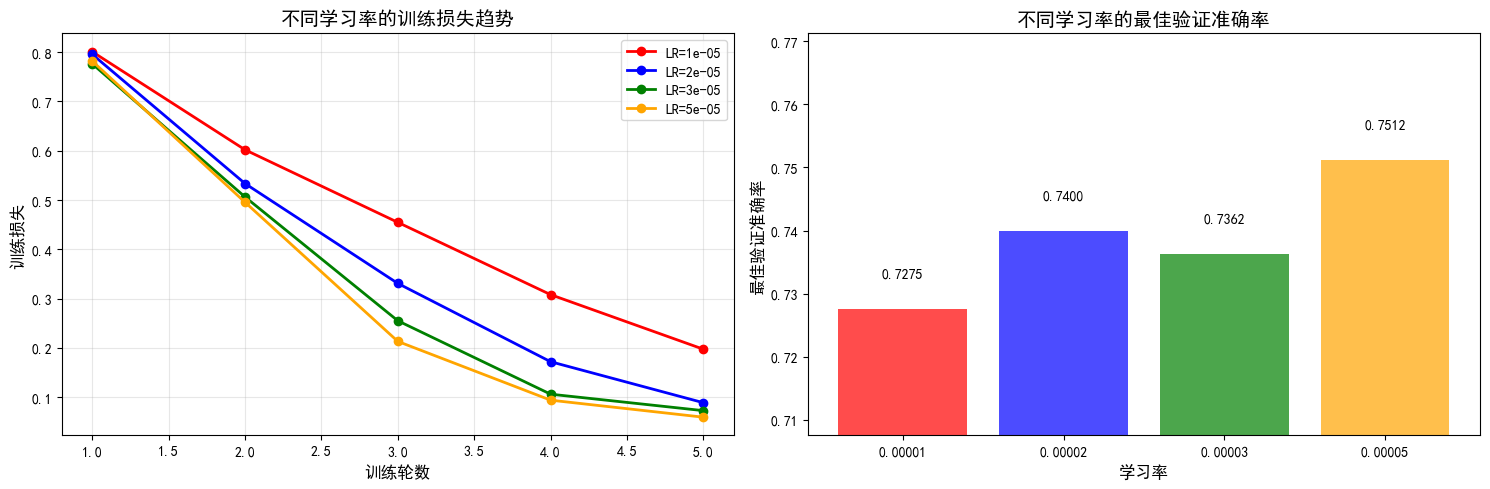

In [ ]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 
plt.rcParams['axes.unicode_minus'] = False

# 可视化学习率调优结果：2个子图（损失趋势+准确率对比）
def plot_tune_results(tune_results):
   
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 子图1：不同学习率的训练损失趋势
    colors = ['red', 'blue', 'green', 'orange']
    for i, lr in enumerate(tune_results["lr"]):
        epochs = range(1, len(tune_results["train_losses_per_epoch"][i]) + 1)
        ax1.plot(epochs, tune_results["train_losses_per_epoch"][i], 
                 label=f'LR={lr}', color=colors[i], linewidth=2, marker='o')
    ax1.set_xlabel('训练轮数', fontsize=12)
    ax1.set_ylabel('训练损失', fontsize=12)
    ax1.set_title('不同学习率的训练损失趋势', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 子图2：最佳验证准确率对比（柱状图）
    lrs_str = [f'{lr:.5f}' for lr in tune_results["lr"]]
    ax2.bar(lrs_str, tune_results["best_val_acc"], color=colors, alpha=0.7)
    ax2.set_xlabel('学习率', fontsize=12)
    ax2.set_ylabel('最佳验证准确率', fontsize=12)
    ax2.set_title('不同学习率的最佳验证准确率', fontsize=14, fontweight='bold')
    ax2.set_ylim([min(tune_results["best_val_acc"])-0.02, max(tune_results["best_val_acc"])+0.02])

    # 标注数值
    for i, acc in enumerate(tune_results["best_val_acc"]):
        ax2.text(i, acc+0.005, f'{acc:.4f}', ha='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('learning_rate_tune_results.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_tune_results(tune_results)

#### ② 搜索权重衰减

In [9]:
 # 调超参：权重优化 单独5轮
best_acc=0.0
val_acc=0.0
def tune_weight_decay(weight_decays, num_tune_epochs=5):
    tune_results = {
        "weight_decay": [],
        "best_val_acc": [],
        "train_losses_per_epoch": [],
        "val_accs_per_epoch": []
    }

    for weight_decay in weight_decays:
        print(f"\n=== 权重衰减：{weight_decay} ===")
        # 重新初始化模型
        model = MultimodalSentimentModel(num_classes=3).to(device)
        optimizer = optim.AdamW(
            model.parameters(),lr=5e-5,weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        train_losses = []
        val_accs = []
        best_acc = 0.0

        for epoch in range(num_tune_epochs):
            train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_acc = evaluate(model, val_loader, device, criterion)

            train_losses.append(train_loss)
            val_accs.append(val_acc)
            if val_acc > best_acc:
                best_acc = val_acc

            print(f" Epoch [{epoch+1}/{num_tune_epochs}] | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

        # 保存结果
        tune_results["weight_decay"].append(weight_decay)
        tune_results["best_val_acc"].append(best_acc)
        tune_results["train_losses_per_epoch"].append(train_losses)
        tune_results["val_accs_per_epoch"].append(val_accs)

        # 清理显存
        torch.cuda.empty_cache()

    return tune_results

weight_decays = [1e-4,3e-4, 5e-4]
tune_results = tune_weight_decay(weight_decays, num_tune_epochs=5)


=== 权重衰减：0.0001 ===
 Epoch [1/5] | Train Loss: 0.9004 | Val Acc: 0.7087
 Epoch [2/5] | Train Loss: 0.7706 | Val Acc: 0.7212
 Epoch [3/5] | Train Loss: 0.6737 | Val Acc: 0.7450
 Epoch [4/5] | Train Loss: 0.5882 | Val Acc: 0.7388
 Epoch [5/5] | Train Loss: 0.5046 | Val Acc: 0.7200

=== 权重衰减：0.0003 ===
 Epoch [1/5] | Train Loss: 0.9113 | Val Acc: 0.7125
 Epoch [2/5] | Train Loss: 0.7661 | Val Acc: 0.7450
 Epoch [3/5] | Train Loss: 0.6723 | Val Acc: 0.7350
 Epoch [4/5] | Train Loss: 0.5859 | Val Acc: 0.7438
 Epoch [5/5] | Train Loss: 0.5071 | Val Acc: 0.7512

=== 权重衰减：0.0005 ===
 Epoch [1/5] | Train Loss: 0.9301 | Val Acc: 0.6275
 Epoch [2/5] | Train Loss: 0.7993 | Val Acc: 0.7350
 Epoch [3/5] | Train Loss: 0.6904 | Val Acc: 0.7250
 Epoch [4/5] | Train Loss: 0.6055 | Val Acc: 0.7350
 Epoch [5/5] | Train Loss: 0.5341 | Val Acc: 0.7275


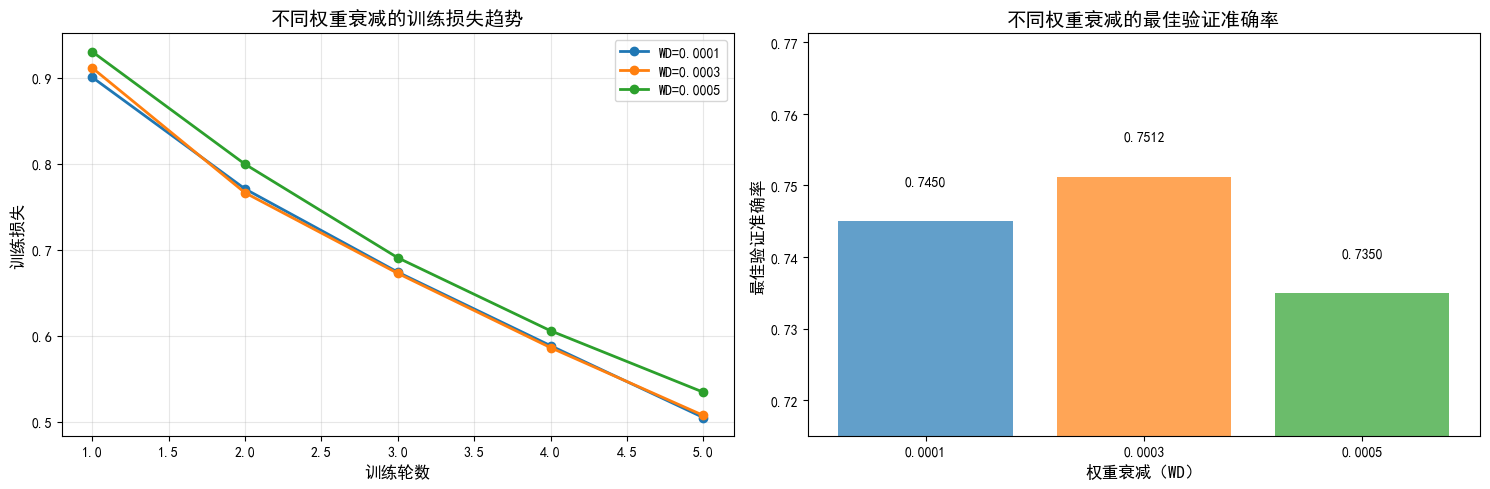

In [ ]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 可视化权重衰减调优结果：（损失趋势+准确率对比）
def plot_weight_decay_tune_results(tune_results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  

    # 子图1：不同权重衰减的训练损失趋势
    for i, wd in enumerate(tune_results["weight_decay"]):
        epochs = range(1, len(tune_results["train_losses_per_epoch"][i]) + 1)
        ax1.plot(epochs, tune_results["train_losses_per_epoch"][i],
                 label=f'WD={wd:.4f}',  
                 color=colors[i], linewidth=2, marker='o')
    ax1.set_xlabel('训练轮数', fontsize=12)
    ax1.set_ylabel('训练损失', fontsize=12)
    ax1.set_title('不同权重衰减的训练损失趋势', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)

    # 子图2：不同权重衰减的最佳验证准确率
    wd_str = [f'{wd:.4f}' for wd in tune_results["weight_decay"]]
    ax2.bar(wd_str, tune_results["best_val_acc"], color=colors, alpha=0.7)
    ax2.set_ylim([min(tune_results["best_val_acc"])-0.02, max(tune_results["best_val_acc"])+0.02])
    ax2.set_xlabel('权重衰减（WD）', fontsize=12)
    ax2.set_ylabel('最佳验证准确率', fontsize=12)
    ax2.set_title('不同权重衰减的最佳验证准确率', fontsize=14, fontweight='bold')

    for i, acc in enumerate(tune_results["best_val_acc"]):
        ax2.text(i, acc + 0.005, f'{acc:.4f}', ha='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('weight_decay_tune_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# 直接调用：和你之前调用plot_tune_results的方式完全一样
plot_weight_decay_tune_results(tune_results)

## 4.最佳超参数训练

In [14]:
model = MultimodalSentimentModel(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # 损失函数
optimizer = optim.AdamW(
    model.parameters(),
    lr=5e-5,          # 对 BERT 友好
    weight_decay=3e-4
)

num_epochs = 10
best_val_acc = 0.0

train_loss_list = []    # 记录每轮训练损失
val_loss_list = []      # 记录每轮验证损失
val_acc_list = []       # 记录每轮验证准确率

torch.cuda.empty_cache()  # 清理上一次训练的显存碎片
for epoch in range(num_epochs):
    print(f"\n=== Epoch [{epoch+1}/{num_epochs}] 开始训练 ===")
    train_loss = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    val_acc, val_loss = evaluate2(model, val_loader, device, criterion)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(
        f"轮次 [{epoch+1}/{num_epochs}] "
        f"训练集损失: {train_loss:.4f} "
        f"验证集损失: {val_loss:.4f}"
        f"验证集准确率: {val_acc:.4f} "
    )

    # 保存验证集最优模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
        print("保存最佳模型")
print(f"\n训练完成！最佳验证准确率：{best_val_acc:.4f}")

d:\Python2\Python311\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
d:\Python2\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python2\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



=== Epoch [1/10] 开始训练 ===
轮次 [1/10] 训练集损失: 0.9192 验证集损失: 0.8220验证集准确率: 0.6475 
保存最佳模型

=== Epoch [2/10] 开始训练 ===
轮次 [2/10] 训练集损失: 0.8069 验证集损失: 0.7643验证集准确率: 0.7200 
保存最佳模型

=== Epoch [3/10] 开始训练 ===
轮次 [3/10] 训练集损失: 0.7080 验证集损失: 0.7326验证集准确率: 0.7350 
保存最佳模型

=== Epoch [4/10] 开始训练 ===
轮次 [4/10] 训练集损失: 0.6032 验证集损失: 0.7462验证集准确率: 0.7462 
保存最佳模型

=== Epoch [5/10] 开始训练 ===
轮次 [5/10] 训练集损失: 0.5251 验证集损失: 0.7387验证集准确率: 0.7362 

=== Epoch [6/10] 开始训练 ===
轮次 [6/10] 训练集损失: 0.4490 验证集损失: 0.7651验证集准确率: 0.7538 
保存最佳模型

=== Epoch [7/10] 开始训练 ===
轮次 [7/10] 训练集损失: 0.4157 验证集损失: 0.8135验证集准确率: 0.7412 

=== Epoch [8/10] 开始训练 ===
轮次 [8/10] 训练集损失: 0.3827 验证集损失: 0.8371验证集准确率: 0.7262 

=== Epoch [9/10] 开始训练 ===
轮次 [9/10] 训练集损失: 0.3563 验证集损失: 0.8576验证集准确率: 0.7388 

=== Epoch [10/10] 开始训练 ===
轮次 [10/10] 训练集损失: 0.3427 验证集损失: 0.8364验证集准确率: 0.7388 

训练完成！最佳验证准确率：0.7538


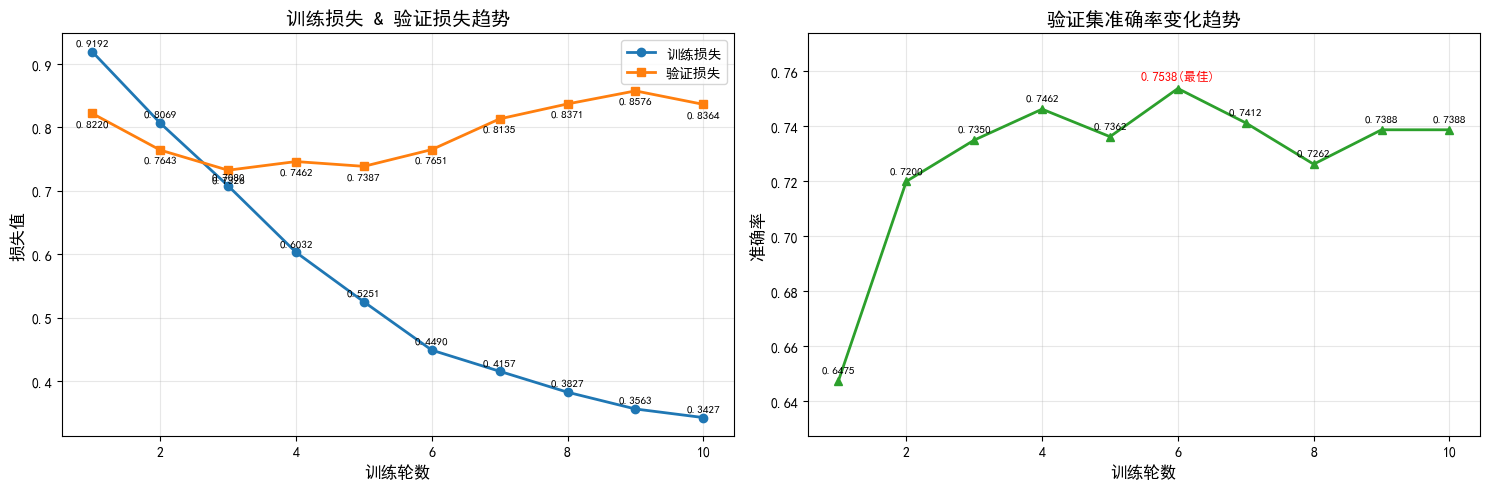

In [15]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 可视化正式训练的指标：损失趋势 + 验证准确率趋势
def plot_train_metrics(train_losses, val_losses, val_accs, num_epochs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    epochs = range(1, num_epochs + 1)

    # 子图1：训练损失 + 验证损失趋势对比
    ax1.plot(epochs, train_losses, label='训练损失', color='#1f77b4', linewidth=2, marker='o')
    ax1.plot(epochs, val_losses, label='验证损失', color='#ff7f0e', linewidth=2, marker='s')
    ax1.set_xlabel('训练轮数', fontsize=12)
    ax1.set_ylabel('损失值', fontsize=12)
    ax1.set_title('训练损失 & 验证损失趋势', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    # 标注每轮损失数值
    for x, y1, y2 in zip(epochs, train_losses, val_losses):
        ax1.text(x, y1+0.01, f'{y1:.4f}', ha='center', fontsize=8)
        ax1.text(x, y2-0.02, f'{y2:.4f}', ha='center', fontsize=8)

    # 子图2：验证集准确率趋势
    ax2.plot(epochs, val_accs, label='验证准确率', color='#2ca02c', linewidth=2, marker='^', markersize=6)
    ax2.set_xlabel('训练轮数', fontsize=12)
    ax2.set_ylabel('准确率', fontsize=12)
    ax2.set_title('验证集准确率变化趋势', fontsize=14, fontweight='bold')
    ax2.set_ylim([min(val_accs)-0.02, max(val_accs)+0.02])  
    ax2.grid(True, alpha=0.3)
    # 标注每轮准确率数值
    best_acc = max(val_accs)
    best_epoch = val_accs.index(best_acc) + 1
    for x, y in zip(epochs, val_accs):
        if x == best_epoch:
            ax2.text(x, y+0.003, f'{y:.4f}(最佳)', ha='center', fontsize=9, color='red', fontweight='bold')
        else:
            ax2.text(x, y+0.003, f'{y:.4f}', ha='center', fontsize=8)

    plt.tight_layout()
    plt.savefig('train_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_train_metrics(train_loss_list, val_loss_list, val_acc_list, num_epochs)

## 5.用最佳模型预测测试集

In [17]:

idx2label = {0: "negative", 1: "neutral", 2: "positive"}

model = MultimodalSentimentModel(num_classes=3).to(device)
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()
print("最佳模型加载完成")

test_guids = [data[0] for data in test_dataset.data_list]

all_preds = [] 
torch.cuda.empty_cache()

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        image = batch["image"].to(device)
        
        logits = model(input_ids, attention_mask, image)
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(batch_preds)

# 验证：预测结果数量和测试集样本数一致，防止错位/漏预测
assert len(all_preds) == len(test_guids), "预测结果数量和测试集样本数不匹配！"
print(f"测试集预测完成，共预测 {len(all_preds)} 个样本")

all_preds_label = [idx2label[idx] for idx in all_preds]
pred_result = [["guid", "label"]]  # 表头
pred_result.extend(zip(test_guids, all_preds_label))

with open("test_prediction.txt", "w", encoding="utf-8") as f:
    for line in pred_result:
        f.write(f"{line[0]},{line[1]}\n")

print("预测结果已保存至 test_prediction.txt")

最佳模型加载完成
测试集预测完成，共预测 511 个样本
预测结果已保存至 test_prediction.txt


## 6. 消融实验

In [19]:
def ablation_evaluate_acc(model, val_loader, device, mode="multimodal"):
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for batch in val_loader:

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            image = batch["image"].to(device)
            labels = batch["label"].to(device)
            
            # 提取特征
            text_feat = model.text_encoder(input_ids, attention_mask)  # (B,768)
            image_feat = model.image_encoder(image)                    # (B,512)
            bs = text_feat.shape[0]
            
            # 模态剥离：另一模态置0
            if mode == "text_only":
                image_feat = torch.zeros(bs, 512).to(device)
            elif mode == "image_only":
                text_feat = torch.zeros(bs, 768).to(device)
            
            # 融合+预测
            fused_feat = torch.cat([text_feat, image_feat], dim=1)
            logits = model.classifier(fused_feat)
            preds = torch.argmax(logits, dim=1)
            
            # 统计准确率
            total_correct += (preds == labels).sum().item()
            total_samples += bs
    model.train()
    return total_correct / total_samples

# 加载最佳多模态模型
model = MultimodalSentimentModel(num_classes=3).to(device)
model.load_state_dict(torch.load("best_model.pt", map_location=device))
print("已加载最佳多模态模型")

# 执行消融实验，仅文本/仅图像的验证集准确率
text_only_acc = ablation_evaluate_acc(model, val_loader, device, mode="text_only")
image_only_acc = ablation_evaluate_acc(model, val_loader, device, mode="image_only")

# 整合所有对比数据（多模态最佳+消融实验结果）
compare_data = {
    "多模态融合（最佳）": best_val_acc,
    "仅文本模态": text_only_acc,
    "仅图像模态": image_only_acc
}

# 打印对比结果（控制台精准看数值）
print("\n消融实验-验证集准确率对比结果")
for name, acc in compare_data.items():
    print(f"{name}: {acc:.4f}")

d:\Python2\Python311\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
d:\Python2\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python2\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


已加载最佳多模态模型

消融实验-验证集准确率对比结果
多模态融合（最佳）: 0.7538
仅文本模态: 0.5988
仅图像模态: 0.6488


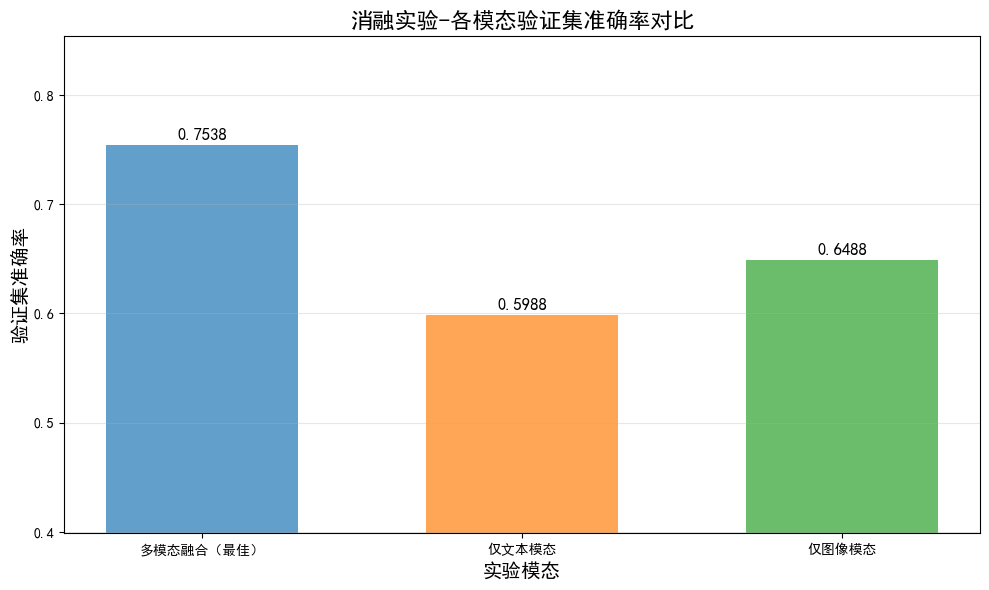

In [23]:
# 可视化消融实验：多模态vs仅文本vs仅图像 验证集准确率对比
def plot_ablation_acc_compare(compare_data):
    # 提取数据
    exp_names = list(compare_data.keys())  # 实验名称
    accs = list(compare_data.values())     # 对应准确率
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # 绘制柱状图
    bars = ax.bar(exp_names, accs, color=colors, alpha=0.7, width=0.6)
    ax.set_ylim([min(accs) - 0.2, max(accs) + 0.1])
    
    ax.set_xlabel('实验模态', fontsize=14)
    ax.set_ylabel('验证集准确率', fontsize=14)
    ax.set_title('消融实验-各模态验证集准确率对比', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar, acc in zip(bars, accs):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.003,
                f'{acc:.4f}', ha='center', va='bottom',
                fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('ablation_acc_compare.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_ablation_acc_compare(compare_data)